# MagGeo - Sequential Mode 

**Authors** | Fernando Benitez-Paez, Urška Demšar, Jed Long, Ciaran Beggan

**Contact**  | [Fernando.Benitez@st-andrews.ac.uk](mailto:Fernando.Benitez@st-andrews.ac.uk), [ud2@st-andrews.ac.uk](mailto:ud2@st-andrews.ac.uk), [jed.long@uwo.ca](mailto:jed.long@uwo.ca), [ciar@bgs.ac.uk](mailto:Fernando.Benitez@st-andrews.ac.uk)

**Keywords** | Bird migration, data fusion, Earth’s magnetic field, Swarm, GPS tracking 

## Overview

This Jupyter Notebook will guide you through the required steps to annotate your GPS tracking data with the earth's magnetic field data from Swarm (European Space Agency). This version is called Sequential Mode, alternatively you can use Parallel Mode to take advantage of parallelized computing if required. More information about the Swarm satellites can be found in the Main Document on the MagGeo github repository. This script will use a sequential loop to run the annotation process for each GPS Point (row) from your data.

To execute the code, you can go through each cell (pressing <code>Crtl+Enter</code>), you will also find inner comments `##` to describe each particular step. If you are not familiar with using Jupyter Notebooks, you might want to take some time to learn how first, for example take a look at the <code>notebook-basics.ipynb</code> Notebook inside MagGeo.

## Data requirements

<div class="alert alert-warning" role="alert">
  <strong>🔎 Your trajectory must be in a csv format:</strong>

There are three columns that  must be included in your GPS trajectory. Make sure your GPS trajectory includes  **Latitude** , **Longitude** and **timestamp**. We suggest that the Timestamp column follow the day/month/year Hour:Minute (**dd/mm/yyyy HH:MM:SS**) format, Latitude and Longitude should be in decimal degrees (WGS84). Optionally an altitude column can be used providing altitude (the altitude must be in **km**). Other Columns will be ignored. Here it is an example of how your GPS track should look:

<img src="../images/TableExample.png">

For this example we are reading the <strong>BirdGPSTrajectory.csv</strong> file. If you want to run the method using your own csv file, make sure you store your the file in the <code>./data</code> folder. For more information about the dataset we used in this example go to the Main Notebook.
</div>

## Import the required python libraries

In [6]:
import datetime as dt
from datetime import timedelta
import sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from viresclient import set_token
sys.path.append("..")

import utilities

from utilities.MagGeoFunctions import getGPSData
from utilities.MagGeoFunctions import Get_Swarm_residuals
from utilities.MagGeoFunctions import ST_IDW_Process
from utilities.MagGeoFunctions import CHAOS_ground_values

## Add your VirES web client Token

The **VirES client API**, requires a token. Before start you need to get your own VirES token. You can visit https://vires.services/ to get yours, and then add it into the next cell.

In [7]:
set_token("https://vires.services/ows", set_default=True)

Setting access token for https://vires.services/ows... Generate a token at https://vires.services/accounts/tokens/

Token saved for https://vires.services/ows


## Read the GPS track
The following steps will load the GPS track from a csv file, and set some requirements before downloading geomagnetic data from Swarm. If your csv track file doesnt not have any altitude attribute, MagGeo will use sea level as your altitude (i.e., 0 Km). **Altitude column units must be Km**

In [8]:
base_dir = str(Path(os.getcwd()).parent)  # Get main MagGeo directory (should be parent to this file)
temp_results_dir = os.path.join(base_dir, "temp_data")
results_dir = os.path.join(base_dir, "results")
data_dir = os.path.join(base_dir, "data")

In [ ]:
#Make sure the csv file of your trackectory is stored in the Data folder.
#Enter the name of your GPS track csv file including the extension .csv  and press Enter (e.g. BirdGPSTrajectory.csv)

gpsfilename=input("What is the name of your .csv file?: ") # i.e BirdGPSTrajectory.csv
Lat=input("Enter the name of your Latitude column?: ") #i.e location-lat
Long=input("Enter the name of your Longitud column?: ") # i.e location-long
DateTime=input("Enter the date and time column name?: ") # i.e timestamp
altitude = input("Enter the Altitude column name?, if you don't have the altitude column, just press Enter: ")

# i.e height (Only in KM)
#If your csv track file doesnt not have any altitude attribute, MagGeo will use sea level as your altitude (i.e. 0 Km).

In [9]:
gpsfilename= "BirdGPSTrajectoryTest.csv"
Lat="location-lat"
Long="location-long"
DateTime="timestamp"
altitude = "height"

In [10]:
# Here MagGeo is reading your CSV file, taking the Lat, Long, Date&Time and Altitutes attributes and compute, some aditional attrubutes we need to the annotation process.
# Setting the date and time attributes for the required format and computing the epoch column. Values like Maximum and Minimun Date and time are also calculated.
GPSData = getGPSData(gpsfilename,Lat,Long,DateTime,altitude)
GPSData

,gpsDateTime,gpsLong,gpsLat,gpsAltitude,epoch,dates,times
0,2014-09-08 05:54:00,68.307333,70.854717,0.000,1410155640,2014-09-08,05:54:00
1,2014-09-08 06:10:00,67.975050,70.830300,0.406,1410156600,2014-09-08,06:10:00
2,2014-09-08 06:26:00,67.752417,70.761717,0.498,1410157560,2014-09-08,06:26:00
3,2014-09-08 06:42:00,67.561983,70.686517,0.787,1410158520,2014-09-08,06:42:00
4,2014-09-08 07:14:00,67.548317,70.685450,0.337,1410160440,2014-09-08,07:14:00
...,...,...,...,...,...,...,...
194,2014-09-27 11:09:00,49.503800,67.735100,0.098,1411816140,2014-09-27,11:09:00
195,2014-09-27 11:25:00,49.503767,67.735100,0.099,1411817100,2014-09-27,11:25:00
196,2014-09-27 11:40:00,49.503667,67.735100,0.100,1411818000,2014-09-27,11:40:00
197,2014-09-27 11:56:00,49.503650,67.735100,0.100,1411818960,2014-09-27,11:56:00


## Validate the correct amount of Swarm measures

The following loop is identifiying the time and validating if the time is less than 4:00 hours and more than 20:00 hours to bring one extra day of data. The result of this validation is written in an empty python list which will be later validated to get the unique dates. This avoids duplicate downloading of data for the same day and reduces overall computational time.

In [11]:
datestimeslist = []
for index, row in GPSData.iterrows():
    datetimerow  = row['gpsDateTime']
    daterow = row['dates']
    hourrow = row['times']
    hourrow = hourrow.strftime('%H:%M:%S')
    if hourrow < '04:00:00':
        date_bfr = daterow - (timedelta(days=1))
        datestimeslist.append(daterow)
        datestimeslist.append(date_bfr)
    if hourrow > '20:00:00':
        Date_aft = daterow + (timedelta(days=1))
        datestimeslist.append(daterow)
        datestimeslist.append(Date_aft)  
    else:
        datestimeslist.append(daterow)

Getting a list of unique dates to download the Swarm Data

In [13]:
def uniquelistdates(list): 
    x = np.array(list) 
    uniquelist = np.unique(x)
    return uniquelist

uniquelist_dates = uniquelistdates(datestimeslist)
uniquelist_dates

array([datetime.date(2014, 8, 30), datetime.date(2014, 9, 8),
       datetime.date(2014, 9, 21), datetime.date(2014, 9, 22),
       datetime.date(2014, 9, 27), datetime.date(2014, 9, 30),
       datetime.date(2014, 10, 1), datetime.date(2014, 10, 2),
       datetime.date(2014, 10, 3), datetime.date(2014, 10, 4)],
      dtype=object)

## Download Swarm residuals data

Once the date and time columns have been defined and the unique dates are identified the script can start the download process. Usually the data from Swarm is requested using only one satellite, however **MagGeo** will use the magnetic measures from the three satellite of the Swarm Mission (Alpha, Bravo, Charlie). Be aware satellite Charlie, got its AMS broken earlier in the mission, although the initial dates still have valid data MagGeo can use.


<div class="alert alert-info" role="alert">
📘 <strong>Be aware:</strong> Due to the amount of dates in the demo GPS track (42 days), the time to process the sample data will take approximately 10 minutes. Unfortunatly the download process migth be a slow process, particually for the magnetic models data MagGeo requieres.</div>

Set a connection to the <code>VirES client</code> and using the function <code>Get_Swarm_residuals</code> we will get the swarm residuals for the dates included in the previous list.

In [14]:
%%time

hours_t_day = 24 #MagGeo needs the entire Swarm data for each day of the identified day.
hours_added = dt.timedelta(hours = hours_t_day)

listdfa = []
listdfb = []
listdfc = []

for d in tqdm(uniquelist_dates, desc="Getting Swarm Data"):
    #print("Getting Swarm data for date:",d )
    startdate = dt.datetime.combine(d, dt.datetime.min.time())
    enddate = startdate + hours_added
    SwarmResidualsA,SwarmResidualsB,SwarmResidualsC = Get_Swarm_residuals(startdate, enddate)
    listdfa.append(SwarmResidualsA)
    listdfb.append(SwarmResidualsB)
    listdfc.append(SwarmResidualsC)

Getting Swarm Data:   0%|          | 0/10 [00:00<?, ?it/s]

Getting Swarm data for date: 2014-08-30


Getting Swarm Data:  10%|█         | 1/10 [00:16<02:24, 16.05s/it]

Getting Swarm data for date: 2014-09-08


Getting Swarm Data:  20%|██        | 2/10 [00:30<02:00, 15.03s/it]

Getting Swarm data for date: 2014-09-21


Getting Swarm Data:  30%|███       | 3/10 [00:44<01:43, 14.82s/it]

Getting Swarm data for date: 2014-09-22


Getting Swarm Data:  40%|████      | 4/10 [00:59<01:27, 14.65s/it]

Getting Swarm data for date: 2014-09-27


Getting Swarm Data:  50%|█████     | 5/10 [01:14<01:13, 14.68s/it]

Getting Swarm data for date: 2014-09-30


Getting Swarm Data:  60%|██████    | 6/10 [01:28<00:58, 14.68s/it]

Getting Swarm data for date: 2014-10-01


Getting Swarm Data:  70%|███████   | 7/10 [01:43<00:43, 14.61s/it]

Getting Swarm data for date: 2014-10-02


Getting Swarm Data:  80%|████████  | 8/10 [01:57<00:29, 14.52s/it]

Getting Swarm data for date: 2014-10-03


Getting Swarm Data:  90%|█████████ | 9/10 [02:12<00:14, 14.71s/it]

Getting Swarm data for date: 2014-10-04


Getting Swarm Data: 100%|██████████| 10/10 [02:27<00:00, 14.73s/it]

CPU times: total: 6.48 s
Wall time: 2min 27s


**Concat the previous results and temporally save the requested data locally:** Integrate the previous list for all dates, into pandas dataframes. We will temporally saved the previous results, in case you need to re-run MagGeo, with the following csv files you will not need to run the download process.

In [15]:
%%time
TotalSwarmRes_A = pd.concat(listdfa, join='outer', axis=0)
TotalSwarmRes_A.to_csv (os.path.join(temp_results_dir,'TotalSwarmRes_A.csv'), header=True)
TotalSwarmRes_B = pd.concat(listdfb, join='outer', axis=0)
TotalSwarmRes_B.to_csv (os.path.join(temp_results_dir,'TotalSwarmRes_B.csv'), header=True)
TotalSwarmRes_C = pd.concat(listdfc, join='outer', axis=0)
TotalSwarmRes_C.to_csv (os.path.join(temp_results_dir,'TotalSwarmRes_C.csv'), header=True)
TotalSwarmRes_A #If you need to take a look of the Swarm Data, you can print TotalSwarmRes_B, or TotalSwarmRes_C

CPU times: total: 2.22 s
Wall time: 2.22 s


,Flags_B,Longitude,Latitude,F_res,Radius,Flags_F,Kp,Spacecraft,N_res,E_res,C_res,timestamp
epoch,,,,,,,,,,,,
1409356800,0,-152.625235,58.858304,-3.866939,6833692.37,1,3.7,A,-4.114730,-51.954474,1.315655,2014-08-30 00:00:00
1409356830,0,-152.399996,60.771216,1.113981,6833454.35,1,3.7,A,-4.169068,-50.670654,6.083260,2014-08-30 00:00:30
1409356860,0,-152.130234,62.683150,6.590280,6833229.58,1,3.7,A,-4.447560,-54.212642,11.681218,2014-08-30 00:01:00
1409356890,0,-151.805863,64.593868,10.575166,6833018.63,1,3.7,A,-14.275096,-41.226261,16.607236,2014-08-30 00:01:30
1409356920,0,-151.413545,66.503054,11.535754,6832822.02,1,3.7,A,-43.661801,-35.095157,22.473850,2014-08-30 00:02:00
...,...,...,...,...,...,...,...,...,...,...,...,...
1412467050,0,159.358993,57.376566,-4.226407,6833117.34,1,1.7,A,-0.570220,-7.526305,-4.687502,2014-10-04 23:57:30
1412467080,0,159.555038,59.290372,-4.458894,6832843.95,1,1.7,A,0.016828,-5.583012,-5.046979,2014-10-04 23:58:00
1412467110,0,159.789418,61.203362,-4.855811,6832582.83,1,1.7,A,-0.752041,-4.098452,-5.164385,2014-10-04 23:58:30


## Spatio-Temporal filter and interpolation process (ST-IDW) 

Once we have requested the swarm data, now we need to `filter` in space and time the available points to compute the magnetic values (NEC frame) for each GPS point based on its particular date and time. The function <code>ST_IDW_Process</code> takes the GPS track and the downloaded data from swarm to filter in space and time based on the criteria defined in our method. With the swarm data filtered we interpolate (IDW) the NEC components for each GPS data point.

In [16]:
%%time
#Sequential mode, applying a traditional loop using iterrows.
if __name__ == '__main__':
    dn = [] ## List used to add all the GPS points with the annotated MAG Data. See the last bullet point of this process        
    for index, row in tqdm(GPSData.iterrows(), total=GPSData.shape[0], desc="Annotating the GPS Trayectory"):
        GPSLat = row['gpsLat']
        GPSLong = row['gpsLong']
        GPSDateTime = row['gpsDateTime']
        GPSTime = row['epoch']
        GPSAltitude = row['gpsAltitude']
        #print("Process for:", index,"DateTime:",GPSDateTime)
        try:
            result=ST_IDW_Process(GPSLat,GPSLong,GPSAltitude, GPSDateTime,GPSTime, TotalSwarmRes_A, TotalSwarmRes_B, TotalSwarmRes_C)
            dn.append(result)
        except:
            #print("Ups!.That was a bad Swarm Point, let's keep working with the next point")
            result_badPoint= {'Latitude': GPSLat, 'Longitude': GPSLong, 'Altitude':GPSAltitude, 'DateTime': GPSDateTime, 'N_res': np.nan, 'E_res': np.nan, 'C_res':np.nan, 'TotalPoints':0, 'Minimum_Distance':np.nan, 'Average_Distance':np.nan}  
            dn.append(result_badPoint)
            continue

Annotating the GPS Trayectory: 100%|██████████| 199/199 [00:13<00:00, 14.81it/s]

CPU times: total: 13.1 s
Wall time: 13.4 s


Temporally save the ST-IDW result locally. Still MagGeo needs to run the calculation of geomagnetic components, brining the magnetic values at the altitude provided for your GPS track.

In [17]:
GPS_ResInt = pd.DataFrame(dn)
GPS_ResInt.to_csv (os.path.join(temp_results_dir,"GPS_ResInt.csv"), header=True)
GPS_ResInt

,Latitude,Longitude,Altitude,DateTime,N_res,E_res,C_res,TotalPoints,Minimum_Distance,Average_Distance,Kp
0,70.854717,68.307333,0.000,2014-09-08 05:54:00,-14.792744,9.893843,1.070834,46,327.950987,665.008368,1.308696
1,70.830300,67.975050,0.406,2014-09-08 06:10:00,-14.289337,9.218836,1.152009,46,340.038476,667.146029,1.308696
2,70.761717,67.752417,0.498,2014-09-08 06:26:00,-11.307214,7.350759,0.933347,55,348.223318,678.815409,1.190909
3,70.686517,67.561983,0.787,2014-09-08 06:42:00,-10.696700,6.642314,0.991916,55,355.472899,680.040733,1.190909
4,70.685450,67.548317,0.337,2014-09-08 07:14:00,-9.545359,5.480128,1.054123,55,355.980432,680.062802,1.190909
...,...,...,...,...,...,...,...,...,...,...,...
194,67.735100,49.503800,0.098,2014-09-27 11:09:00,-30.611759,17.836261,3.404430,58,314.462546,745.632468,3.162069
195,67.735100,49.503767,0.099,2014-09-27 11:25:00,-27.752866,16.808853,2.674486,39,314.463935,735.353061,3.094872
196,67.735100,49.503667,0.100,2014-09-27 11:40:00,-27.891632,16.969719,2.619968,39,314.468143,735.351634,3.094872
197,67.735100,49.503650,0.100,2014-09-27 11:56:00,-28.010100,17.111878,2.556850,39,314.468858,735.351391,3.094872


## Compute the magnetic components at the trajectory altitute using CHAOS model

The function <code>CHAOS_ground_values</code> is used to run the calculation of magnetic components. This adjustment requeries the magnetic components at the trajectory altitude (or at the ground level) using CHAOS (theta, phi, radial). This process also further conducts the rotation and transformation between a geocentric earth-based reference system (CHAOS) and geodetic earth-based reference system (GPS track). Once the corrected values are calculated the non-necesary columns are removed. For more information about this process go to the Main Notebook.

In [18]:
%%time
X_obs, Y_obs, Z_obs, X_obs_internal, Y_obs_internal, Z_obs_internal =CHAOS_ground_values(GPS_ResInt)
GPS_ResInt['N'] =pd.Series(X_obs)
GPS_ResInt['E'] =pd.Series(Y_obs)
GPS_ResInt['C'] =pd.Series(Z_obs)
GPS_ResInt['N_Obs'] =pd.Series(X_obs_internal)
GPS_ResInt['E_Obs'] =pd.Series(Y_obs_internal)
GPS_ResInt['C_Obs'] =pd.Series(Z_obs_internal)

GPS_ResInt.drop(columns=['N_res', 'E_res','C_res'], inplace=True)
GPS_ResInt

CPU times: total: 1.84 s
Wall time: 1.93 s


,Latitude,Longitude,Altitude,DateTime,TotalPoints,Minimum_Distance,Average_Distance,Kp,N,E,C,N_Obs,E_Obs,C_Obs
0,70.854717,68.307333,0.000,2014-09-08 05:54:00,46,327.950987,665.008368,1.308696,6949.075221,3851.112405,57703.184834,6970.420967,3838.494559,57689.934814
1,70.830300,67.975050,0.406,2014-09-08 06:10:00,46,340.038476,667.146029,1.308696,6985.622920,3866.290909,57644.882192,7006.455690,3854.336448,57631.552162
2,70.761717,67.752417,0.498,2014-09-08 06:26:00,55,348.223318,678.815409,1.190909,7035.516299,3877.393141,57609.773161,7053.372261,3867.299155,57596.673601
3,70.686517,67.561983,0.787,2014-09-08 06:42:00,55,355.472899,680.040733,1.190909,7082.942040,3886.893072,57574.854667,7100.195014,3877.501165,57561.704322
4,70.685450,67.548317,0.337,2014-09-08 07:14:00,55,355.980432,680.062802,1.190909,7086.053455,3888.434162,57584.748919,7102.154616,3880.203863,57571.538841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,67.735100,49.503800,0.098,2014-09-27 11:09:00,58,314.462546,745.632468,3.162069,9984.190384,3989.648532,54839.583749,10022.560998,3970.721884,54824.183309
195,67.735100,49.503767,0.099,2014-09-27 11:25:00,39,314.463935,735.353061,3.094872,9987.045686,3988.615518,54838.817622,10022.559137,3970.716277,54824.153874
196,67.735100,49.503667,0.100,2014-09-27 11:40:00,39,314.468143,735.351634,3.094872,9986.907471,3988.768074,54838.723643,10022.559815,3970.707962,54824.114084
197,67.735100,49.503650,0.100,2014-09-27 11:56:00,39,314.468858,735.351391,3.094872,9986.789499,3988.909547,54838.658178,10022.560459,3970.707276,54824.111456


##  The final result 

With the NEC components for each GPS Track point, it is possible to compute the aditional magnetic components. For more information about the magnetic components and their relevance go to the main paper or notebook.

<div class="alert alert-info" role="alert">
    <strong>📘 The annotated dataframe will include the following attributes:</strong> If you need more information about how the geomagnetic components are described go to the main MagGeo Notebook (Add Link).
    <ul>
      <li><strong>Latitude</strong> from the GPS Track.</li>
      <li><strong>Longitude</strong> from the GPS Track.</li>
      <li><strong>Timestamp</strong> from the GPS Track.</li>
      <li><strong>Magnetic Field Intensity</strong>  mapped as Fgps in nanoTeslas (nT).</li>
      <li><strong>N (Northwards) component</strong> mapped as N in nanoTeslas (nT).</li>
      <li><strong>E (Eastwards) component</strong> mapped as E. in nanoteslas (nT).</li>
      <li><strong>C (Downwards or Center)</strong> component mapped as C in nanoTeslas (nT).</li>
      <li><strong>Horizontal component</strong> mapped as H in nanoTeslas (nT).</li>
      <li><strong>Magnetic Inclination </strong> mapped as I in degrees.</li> 
      <li><strong>Magnetic Declination or dip angle</strong> mapped as D in degrees</li>
      <li><strong>Kp Index</strong> mapped as kp</li>
      <li><strong>Total Points</strong> as the amount of Swarm points included in the ST-IDW process from the three satellites.</li>
      <li><strong>Minimum Distance</strong> mapped as MinDist, representing the minimum distance from a Swarm points and each GPS point location.</li>
      <li><strong>Average Distance</strong> mapped as AvDist, representing the average distance between the Swarm points and the GPS point location.</li>
    </ul>

</div> 

In [19]:
%%time
# Having Intepolated and weighted the magnetic values, we can compute the other magnectic components. 
GPS_ResInt['H'] = np.sqrt((GPS_ResInt['N']**2)+(GPS_ResInt['E']**2))
#check the arcgtan in python., From arctan2 is saver.
DgpsRad = np.arctan2(GPS_ResInt['E'],GPS_ResInt['N'])
GPS_ResInt['D'] = np.degrees(DgpsRad)
IgpsRad = np.arctan2(GPS_ResInt['C'],GPS_ResInt['H'])
GPS_ResInt['I'] = np.degrees(IgpsRad)
GPS_ResInt['F'] = np.sqrt((GPS_ResInt['N']**2)+(GPS_ResInt['E']**2)+(GPS_ResInt['C']**2))
GPS_ResInt

CPU times: total: 0 ns
Wall time: 8.35 ms


,Latitude,Longitude,Altitude,DateTime,TotalPoints,Minimum_Distance,Average_Distance,Kp,N,E,C,N_Obs,E_Obs,C_Obs,H,D,I,F
0,70.854717,68.307333,0.000,2014-09-08 05:54:00,46,327.950987,665.008368,1.308696,6949.075221,3851.112405,57703.184834,6970.420967,3838.494559,57689.934814,7944.854510,28.994810,82.160529,58247.560062
1,70.830300,67.975050,0.406,2014-09-08 06:10:00,46,340.038476,667.146029,1.308696,6985.622920,3866.290909,57644.882192,7006.455690,3854.336448,57631.552162,7984.180169,28.962950,82.114343,58195.185161
2,70.761717,67.752417,0.498,2014-09-08 06:26:00,55,348.223318,678.815409,1.190909,7035.516299,3877.393141,57609.773161,7053.372261,3867.299155,57596.673601,8033.222713,28.859910,82.061748,58167.161103
3,70.686517,67.561983,0.787,2014-09-08 06:42:00,55,355.472899,680.040733,1.190909,7082.942040,3886.893072,57574.854667,7100.195014,3877.501165,57561.704322,8079.356763,28.756578,82.011966,58138.970542
4,70.685450,67.548317,0.337,2014-09-08 07:14:00,55,355.980432,680.062802,1.190909,7086.053455,3888.434162,57584.748919,7102.154616,3880.203863,57571.538841,8082.825855,28.755544,82.009936,58149.250914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,67.735100,49.503800,0.098,2014-09-27 11:09:00,58,314.462546,745.632468,3.162069,9984.190384,3989.648532,54839.583749,10022.560998,3970.721884,54824.183309,10751.806966,21.781482,78.907336,55883.640708
195,67.735100,49.503767,0.099,2014-09-27 11:25:00,39,314.463935,735.353061,3.094872,9987.045686,3988.615518,54838.817622,10022.559137,3970.716277,54824.153874,10754.075287,21.770726,78.904903,55883.325362
196,67.735100,49.503667,0.100,2014-09-27 11:40:00,39,314.468143,735.351634,3.094872,9986.907471,3988.768074,54838.723643,10022.559815,3970.707962,54824.114084,10754.003515,21.771754,78.904956,55883.219327
197,67.735100,49.503650,0.100,2014-09-27 11:56:00,39,314.468858,735.351391,3.094872,9986.789499,3988.909547,54838.658178,10022.560459,3970.707276,54824.111456,10753.946432,21.772687,78.905001,55883.144101


The previous dataframe (GPS_ResInt), MagGeo has computed the geomagnetic components for each locations and time of your CSV trajectory. Now we will finish up combining the original atributes from your CSV with the annotated results from MagGeo.

In [20]:
%%time
originalGPSTrack=pd.read_csv(os.path.join(data_dir,gpsfilename))
MagGeoResult = pd.concat([originalGPSTrack, GPS_ResInt], axis=1)
#Drop duplicated columns. Latitude, Longitued, and DateTime will not be part of the final result.
MagGeoResult.drop(columns=['Latitude', 'Longitude', 'DateTime'], inplace=True)
MagGeoResult

CPU times: total: 15.6 ms
Wall time: 9.37 ms


,timestamp,location-long,location-lat,height,individual_id,Altitude,TotalPoints,Minimum_Distance,Average_Distance,Kp,N,E,C,N_Obs,E_Obs,C_Obs,H,D,I,F
0,08/09/2014 05:54,68.307333,70.854717,0.000,1,0.000,46,327.950987,665.008368,1.308696,6949.075221,3851.112405,57703.184834,6970.420967,3838.494559,57689.934814,7944.854510,28.994810,82.160529,58247.560062
1,08/09/2014 06:10,67.975050,70.830300,0.406,1,0.406,46,340.038476,667.146029,1.308696,6985.622920,3866.290909,57644.882192,7006.455690,3854.336448,57631.552162,7984.180169,28.962950,82.114343,58195.185161
2,08/09/2014 06:26,67.752417,70.761717,0.498,1,0.498,55,348.223318,678.815409,1.190909,7035.516299,3877.393141,57609.773161,7053.372261,3867.299155,57596.673601,8033.222713,28.859910,82.061748,58167.161103
3,08/09/2014 06:42,67.561983,70.686517,0.787,1,0.787,55,355.472899,680.040733,1.190909,7082.942040,3886.893072,57574.854667,7100.195014,3877.501165,57561.704322,8079.356763,28.756578,82.011966,58138.970542
4,08/09/2014 07:14,67.548317,70.685450,0.337,1,0.337,55,355.980432,680.062802,1.190909,7086.053455,3888.434162,57584.748919,7102.154616,3880.203863,57571.538841,8082.825855,28.755544,82.009936,58149.250914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,27/09/2014 11:09,49.503800,67.735100,0.098,2,0.098,58,314.462546,745.632468,3.162069,9984.190384,3989.648532,54839.583749,10022.560998,3970.721884,54824.183309,10751.806966,21.781482,78.907336,55883.640708
195,27/09/2014 11:25,49.503767,67.735100,0.099,2,0.099,39,314.463935,735.353061,3.094872,9987.045686,3988.615518,54838.817622,10022.559137,3970.716277,54824.153874,10754.075287,21.770726,78.904903,55883.325362
196,27/09/2014 11:40,49.503667,67.735100,0.100,2,0.100,39,314.468143,735.351634,3.094872,9986.907471,3988.768074,54838.723643,10022.559815,3970.707962,54824.114084,10754.003515,21.771754,78.904956,55883.219327
197,27/09/2014 11:56,49.503650,67.735100,0.100,2,0.100,39,314.468858,735.351391,3.094872,9986.789499,3988.909547,54838.658178,10022.560459,3970.707276,54824.111456,10753.946432,21.772687,78.905001,55883.144101


## Export the final results to a CSV file

In [21]:
%%time
#Exporting the CSV file
outputfile ="GeoMagResult_"+gpsfilename
export_csv = MagGeoResult.to_csv (os.path.join(results_dir,outputfile), index = None, header=True)


CPU times: total: 15.6 ms
Wall time: 15.1 ms


## Validate the results ( Optional)
To validate the results we plot the `Fgps`column.

Text(0, 0.5, '# of measurements')

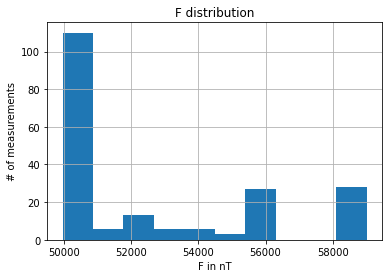

In [22]:
## Creating a copy of the results and setting the Datetime Column as dataframe index.
ValidateDF = GPS_ResInt.copy()
ValidateDF.set_index("DateTime", inplace=True)
## Plotting the F column.
hist = ValidateDF.hist(column='F')
plt.title('F distribution')
plt.xlabel('F in nT')
plt.ylabel('# of measurements')

## Map the GPS Track using the annotated Magnetic Values (Optional)

Now we are going to plot the annotated GPS track stored into the MagDataFinal dataframe to see the different magnetic components in a map to have a better prespective of the impact of the earth magnetic field.

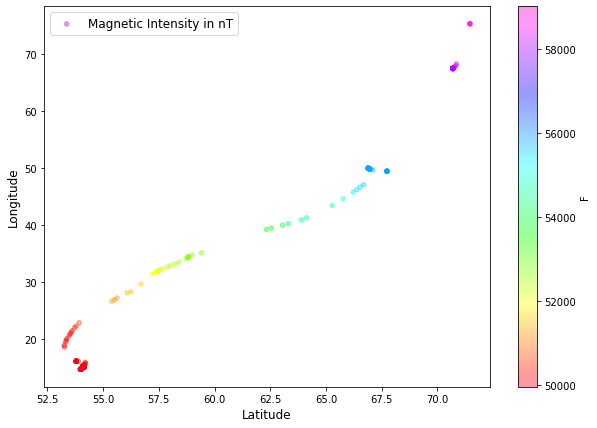

In [23]:
ValidateDF.plot(kind="scatter", x="Latitude", y="Longitude",
    label="Magnetic Intensity in nT",
    c="F", cmap=plt.get_cmap("gist_rainbow"),
    colorbar=True, alpha=0.4, figsize=(10,7),
    sharex=False #This is only needed to get the x-axis label working due to a current bug in pandas plot.
    
)

plt.ylabel("Longitude", fontsize=12)
plt.xlabel("Latitude", fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [24]:
import geopandas
import geoplot
gdf = geopandas.GeoDataFrame(ValidateDF, geometry=geopandas.points_from_xy(ValidateDF.Longitude, ValidateDF.Latitude))
gdf.head()

,Latitude,Longitude,Altitude,TotalPoints,Minimum_Distance,Average_Distance,Kp,N,E,C,N_Obs,E_Obs,C_Obs,H,D,I,F,geometry
DateTime,,,,,,,,,,,,,,,,,,
2014-09-08 05:54:00,70.854717,68.307333,0.000,46,327.950987,665.008368,1.308696,6949.075221,3851.112405,57703.184834,6970.420967,3838.494559,57689.934814,7944.854510,28.994810,82.160529,58247.560062,POINT (68.30733 70.85472)
2014-09-08 06:10:00,70.830300,67.975050,0.406,46,340.038476,667.146029,1.308696,6985.622920,3866.290909,57644.882192,7006.455690,3854.336448,57631.552162,7984.180169,28.962950,82.114343,58195.185161,POINT (67.97505 70.83030)
2014-09-08 06:26:00,70.761717,67.752417,0.498,55,348.223318,678.815409,1.190909,7035.516299,3877.393141,57609.773161,7053.372261,3867.299155,57596.673601,8033.222713,28.859910,82.061748,58167.161103,POINT (67.75242 70.76172)
2014-09-08 06:42:00,70.686517,67.561983,0.787,55,355.472899,680.040733,1.190909,7082.942040,3886.893072,57574.854667,7100.195014,3877.501165,57561.704322,8079.356763,28.756578,82.011966,58138.970542,POINT (67.56198 70.68652)
2014-09-08 07:14:00,70.685450,67.548317,0.337,55,355.980432,680.062802,1.190909,7086.053455,3888.434162,57584.748919,7102.154616,3880.203863,57571.538841,8082.825855,28.755544,82.009936,58149.250914,POINT (67.54832 70.68545)


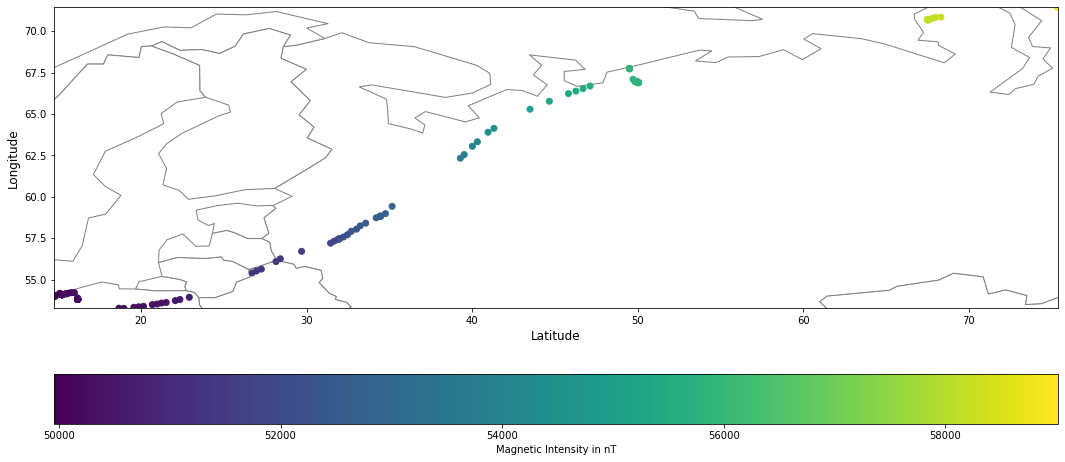

In [25]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(color='white', edgecolor='gray', figsize = (18,8))

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

gdf.plot(ax=ax, column='F', legend=True, 
         legend_kwds={'label': "Magnetic Intensity in nT",
                      'orientation': "horizontal"})
plt.ylabel("Longitude", fontsize=12)
plt.xlabel("Latitude", fontsize=12)

plt.show()

Text(686.1045454545454, 0.5, 'Longitude')

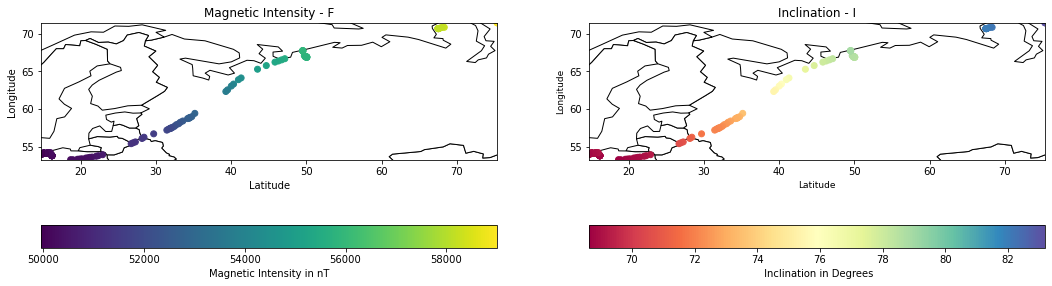

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (18,8))

ax1 = world.plot(ax=ax1, color='white', edgecolor='black')
xlim = ([gdf.total_bounds[0],  gdf.total_bounds[2]])
ylim = ([gdf.total_bounds[1],  gdf.total_bounds[3]])
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)


gdf.plot(ax=ax1, column='F', legend=True,
         legend_kwds={'label': "Magnetic Intensity in nT",
                      'orientation': "horizontal"})
plt.ylabel("Longitude", fontsize=9)
plt.xlabel("Latitude", fontsize=9)
ax1.set_title('Magnetic Intensity - F')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitude')


ax2 = world.plot( ax=ax2, color='white', edgecolor='black')
xlim = ([gdf.total_bounds[0],  gdf.total_bounds[2]])
ylim = ([gdf.total_bounds[1],  gdf.total_bounds[3]])
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)


# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax2, column='I', legend=True, cmap='Spectral', 
         legend_kwds={'label': " Inclination in Degrees",
                      'orientation': "horizontal"})
ax2.set_title('Inclination - I')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Longitude')